In [1]:
import keras

keras.__version__

Using TensorFlow backend.


'2.2.4'

## 8.2 딥드림 (DeepDream)


- **딥드림**(DeepDream)은 합성곱 신경망이 학습한 표현을 사용하여 예술적으로 이미지를 조작하는 기법이다.

- 2015년 여름 구글이 카페(Caffe) 딥러닝 라이브러리를 사용하여 구현한 것을 처음 공개했다. [[링크](https://ai.googleblog.com/2015/07/deepdream-code-example-for-visualizing.html)] 참고 

- 딥드림 알고리즘은 [5장](https://github.com/ExcelsiorCJH/Deep-Learning-with-Python/blob/master/Chap05-Deep_learning_for_computer_vision/5.4-visualizing-what-convnets-learn.ipynb)에서 알아본 컨브넷을 거꾸로 실행하는 컨브넷 필터 시각화 기법과 거의 동일하다.
    - 컨브넷 상위 층에 있는 특정 필터의 활성화를 극대화하기 위해 컨브넷의 입력에 경사 상승법(gradient ascent)을 적용했다.
    
    
- 딥드림은 다음과 같은 아이디어를 사용한다.

    - 딥드림에서는 특정 필터가 아니라 전체 층의 활성화를 최대화 한다.
    
    - 빈 이미지나 노이즈가 조금 있는 입력이 아니라 이미 가지고 있는 이미지를 사용한다. 그 결과 기존 시각 패턴을 바탕으로 이미지의 요소들을 다소 예술적인 스타일로 왜곡시킨다.
    
    - 입력 이미지는 시각 품질을 높이기 위해 여러 다른 스케일(**옥타브**)로 처리한다.
        - 옥타브(octave)는 이미지 크기를 일정한 비율로 연속적으로 줄이거나 늘리는 방식을 말한다.

### 8.2.1 케라스 딥드림 구현

ImageNet에서 훈련한 컨브넷을 가지고 시작하겠습니다. 케라스에는 이렇게 사용할 수 있는 컨브넷이 많습니다. VGG16, VGG19, Xception, ResNet50 등입니다. 이 중에 어느 것을 사용해도 딥드림을 구현할 수 있습니다. 당연히 어떤 컨브넷을 선택했느냐에 따라 시각화에 영향을 미칩니다. 각 컨브넷 구조가 학습한 특성이 다르기 때문입니다. 원래 딥드림에서 사용한 컨브넷은 인셉션 모델입니다. 실제로 인셉션이 멋진 딥드림 이미지를 잘 만듭니다. 여기에서도 케라스의 인셉션 V3 모델을 사용하겠습니다.

In [2]:
from keras.applications import inception_v3
from keras import backend as K

# 모델을 훈련하지 않는다. 이 명령은 모든 훈련 연산을 비활성화한다.
K.set_learning_phase(0)

# 합성곱 기반층만 사용한 Inception V3 네트워크를 만든다.
# 사전 훈련된 ImageNet 가중치와 함께 모델을 로드한다.
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

그 다음 손실을 계산합니다. 
- 경사 상승법으로 최대화할 값입니다. 
- 5장 필터 시각화에서 특정 층의 필터 값을 최대화했습니다.
- 여기에서는 여러 층에 있는 **모든 필터 활성화를 동시에 최대화**합니다. 


특별히 상위 층에 있는 활성화의 L2 노름에 대한 가중치 합을 최대화하겠습니다. 
- 정확히 어떤 층들을 선택했는지에 따라 (당연히 최종 손실에 기여한 정도에 따라) 만들어 내는 시각 요소에 큰 영향을 미칩니다. 
- 어떤 층을 선택할지 파라미터로 손쉽게 바꿀 수 있어야 좋습니다. 
- 하위 층은 기하학적인 패턴을 만들고 상위 층은 ImageNet에 있는 클래스로 보이는 시각 요소를 만듭니다(예를 들어 새나 강아지). 

먼저 임의로 네 개의 층을 선택해 보겠습니다. 나중에 다른 설정을 다양하게 시도해 보는 것이 좋습니다:

In [3]:
# 층 이름과 계수를 매핑한 딕셔너리
# 최대화하려는 손실에 층의 활성화가 기여할 양을 정한다.
# 층 이름은 내장된 Inception-V3 애플리케이션에 하드코딩되어 있는 것이다.
# model.summary()를 사용하면 모든 층 이름을 확인할 수 있다.

# model.summary()
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

이제 손실 텐서를 정의하겠습니다. 위에서 선택한 층의 활성화에 대한 **L2 노름**의 **가중치 합**입니다.

In [4]:
# 층 이름과 층 객체를 매핑한 딕셔너리를 만든다.
layer_dict = {layer.name: layer for layer in model.layers}

# 손실을 정의하고 각 층의 기여분을 이 스칼라 변수에 추가한다.
loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    # 층의 출력을 얻는다.
    activation = layer_dict[layer_name].output
    
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    # 층 특성의 L2 노름의 제곱을 손실에 추가한다. 이미지 테두리는 제외하고 손실에 추가한다.
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

그 다음 경사 상승법 과정을 준비합니다:

In [5]:
# 이 텐서는 생성된 딥드림 이미지를 저장한다.
dream = model.input

# 손실에 대한 딥드림 이미지의 그래디언트를 계산한다.
grads = K.gradients(loss, dream)[0]

# 그래디언트를 정규화한다.(이  부분이 중요하다)
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# 주어진 입력 이미지에서 손실과 그래디언트 값을 계산할 케라스 Function 객체를 만든다.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

# 이 함수는 경사 상승법을 여러 번 반복하여 수행한다.
def grdient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
            
        print('...', i, '번째 손실 :', loss_value)
        x += step * grad_values
    return x

마지막으로 진짜 딥드림 알고리즘입니다.

먼저 이미지를 처리하기 위한 스케일(옥타브라고도 부릅니다) 리스트를 정의합니다. 스케일은 이전 스케일보다 1.4배 큽니다(40% 증가합니다). 작은 이미지로 시작해서 점점 크기를 키웁니다:

![](./images/octave.png)

가장 작은 것에서 가장 큰 스케일까지 연속적인 각 단계에서 정의한 손실이 최대화되도록 경사 상승법을 수행합니다. 경상 상승법이 실행된 후 이미지 크기를 40% 증가시킵니다.

- 스케일을 연속적으로 증가시키면서 (점점 뭉개지거나 픽셀 경계가 나타나므로) 이미지 상세를 많이 잃지 않도록 간단한 기교를 사용합니다. 
- 스케일을 늘린 후 이미지에 손실된 디테일을 재주입합니다. 원본 이미지가 크기를 늘렸을 때 어땠는지 알기 때문에 가능합니다. 
- 작은 이미지 크기 S와 큰 이미지 크기 L이 주어지면 크기 L로 변경된 원본 이미지와 크기 S로 변경된 원본 이미지 사이의 차이를 계산합니다. 
    - 이 차이가 S에서 L로 변경되었을 때 잃어버린 디테일입니다.

이 코드는 다음에 나오는 유틸리티 함수를 사용합니다. 넘파이 배열 기반의 함수이며 이름으로 역할을 알 수 있습니다. 이 함수를 사용하려면 싸이파이를 설치해야 합니다.

In [16]:
import scipy
import numpy as np
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    image.save_img(fname, pil_img)


def preprocess_image(image_path):
    # 사진을 열고 크기를 줄이고 인셉션 V3가 인식하는 텐서 포맷으로 변환하는 유틸리티 함수
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # 넘파이 배열을 적절한 이미지 포맷으로 변환하는 유틸리티 함수
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        # inception_v3.preprocess_input 함수에서 수행한 전처리 과정을 복원합니다
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [18]:
import numpy as np

# 하이퍼파라미터를 바꾸면 새로운 효과가 만들어진다.
step = 0.01
num_octave = 3  # 경사 상승법을 실행할 스케일 단계 횟수
octave_scale = 1.4  # 스케일 간의 크기 비율
iterations = 20   # 스케일 단계마다 수행할 경사 상승법 횟수

# 손실이 10보다 커지면 이상한 그림이 되는 것을 피하기 위해
# 경사 상승법 과정을 중지한다.
max_loss = 10.

# 사용할 이미지 경로
base_image_path = '../datasets/original_photo_deep_dream.jpg'

# 기본 이미지를 넘파이 배열로 로드한다.
img = preprocess_image(base_image_path)

# 경사 상승법을 실행할 스케일 크기를 정의한 튜플의 리스트를 준비한다.
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# 이 리스트를 크기 순으로 뒤집는다.
successive_shapes = successive_shapes[::-1]

# 이미지의 넘파이 배열을 가장 작은 스케일로 변경한다.
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('처리할 이미지 크기', shape)
    img = resize_img(img, shape)
    img = grdient_ascent(img,
                         iterations=iterations,
                         step=step,
                         max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale'+str(shape)+'.png')
    
save_img(img, fname='./deepdream-images/final_dream.png')

처리할 이미지 크기 (178, 178)
... 0 번째 손실 : 0.65961754
... 1 번째 손실 : 1.0167829
... 2 번째 손실 : 1.468085
... 3 번째 손실 : 2.0048606
... 4 번째 손실 : 2.6124327
... 5 번째 손실 : 3.0967872
... 6 번째 손실 : 3.5737035
... 7 번째 손실 : 4.0655537
... 8 번째 손실 : 4.4537687
... 9 번째 손실 : 4.858753
... 10 번째 손실 : 5.2522545
... 11 번째 손실 : 5.6779294
... 12 번째 손실 : 6.088588
... 13 번째 손실 : 6.488309
... 14 번째 손실 : 6.857266
... 15 번째 손실 : 7.333903
... 16 번째 손실 : 7.6969967
... 17 번째 손실 : 8.010738
... 18 번째 손실 : 8.392117
... 19 번째 손실 : 8.852909
처리할 이미지 크기 (250, 250)
... 0 번째 손실 : 2.225191
... 1 번째 손실 : 3.5695055
... 2 번째 손실 : 4.720564
... 3 번째 손실 : 5.628797
... 4 번째 손실 : 6.4926066
... 5 번째 손실 : 7.3295765
... 6 번째 손실 : 8.04726
... 7 번째 손실 : 8.736169
... 8 번째 손실 : 9.340403
처리할 이미지 크기 (350, 350)
... 0 번째 손실 : 2.3390033
... 1 번째 손실 : 3.5228078
... 2 번째 손실 : 4.606639
... 3 번째 손실 : 5.494412
... 4 번째 손실 : 6.4494615
... 5 번째 손실 : 7.324793
... 6 번째 손실 : 8.187649
... 7 번째 손실 : 9.1072445


In [19]:
from matplotlib import pyplot as plt

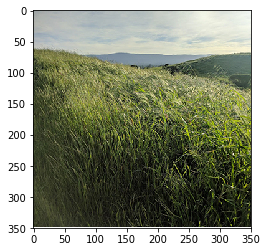

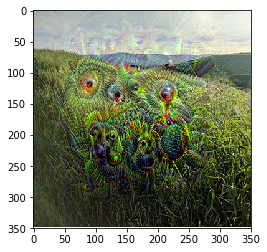

In [20]:
plt.imshow(plt.imread(base_image_path))
plt.figure()

plt.imshow(deprocess_image(np.copy(img)))
plt.show()

### 8.2.2 정리

- 딥드림은 네트워크가 학습한 표현을 기반으로 컨브넷을 거꾸로 실행하여 입력 이미지를 생성한다.

- 이 과정은 이미지 모델 뿐만아니라 음성, 음악 등에도 적용될 수 있다.